# Peptide level intensity normalization across experiments
In this tutorial, we start with a simulated table of peptides, quantified across a set of experiments. 
We will add some extra noise and then perform normalization to correct for that noise.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from omicspylib.plots import plot_density

from omicspylib.datasets.peptides import PeptidesDataset

from omicspylib import __version__

print(f'omicspylib version: {__version__}')

omicspylib version: 0.0.7


The simulated dataset is loaded as a Pandas data frame. Peptide identifiers are under `peptide_id` column, protein identifiers under `protein_id` column and columns `cX_repY` represent measured peptides intensities/quantitative values.

In [55]:
data_df = pd.read_csv('data/peptides_dataset.tsv', sep='\t')
data_df.head(2)

,peptide_id,protein_id,c1_rep1,c1_rep2,c1_rep3,c1_rep4,c1_rep5,c2_rep1,c2_rep2,c2_rep3,c2_rep4,c2_rep5,c3_rep1,c3_rep2,c3_rep3,c3_rep4,c3_rep5
0,pept147,prot0,1740.912460,0.0,1393.260017,4685.874636,513.393605,502.109101,949.462139,0.000000,3006.548317,671.891115,4123.628101,11583.385623,3114.882410,2812.034141,2195.550530
1,pept424,prot0,3668.876134,0.0,0.000000,303.011791,1314.382432,404.828763,3723.604607,11838.405382,7586.141805,0.000000,336.363330,0.000000,200.425728,3891.630707,1395.146624


We will shift the measurements by a fixed value to make the effect of normalization more visible. First we transform the values to approximate normal distribution and then shift by a fixed value. Then we apply a mask to set to 0.0 cases with 0.0 initial value.

In [56]:
exp_col = [c for c in data_df.columns if '_rep' in c]
random_shift = np.random.uniform(0, 5, len(exp_col)).reshape(1, -1)
mask = data_df[exp_col] > 1

data_df[exp_col] = 2**(np.log2(data_df[exp_col]+1) + random_shift)
data_df[exp_col] *= mask
data_df.head(2)

,peptide_id,protein_id,c1_rep1,c1_rep2,c1_rep3,c1_rep4,c1_rep5,c2_rep1,c2_rep2,c2_rep3,c2_rep4,c2_rep5,c3_rep1,c3_rep2,c3_rep3,c3_rep4,c3_rep5
0,pept147,prot0,8207.742261,0.0,3340.489492,9174.312026,1135.664727,1636.533298,23932.710404,0.000000,12038.502978,2916.229804,105123.431332,11897.564858,30812.298059,26757.316943,38482.987426
1,pept424,prot0,17292.141906,0.0,0.000000,595.087184,2904.066879,1320.095946,93785.833003,23282.136174,30369.530123,0.000000,8598.300247,0.000000,1991.856161,37026.338229,24460.121563


Then, we can create the `PeptidesDataset` object from the tabular data and visualize the peptide abundance distribution. There is an significant level of noise that needs to be corrected before attempting any comparison between the experimental conditions.

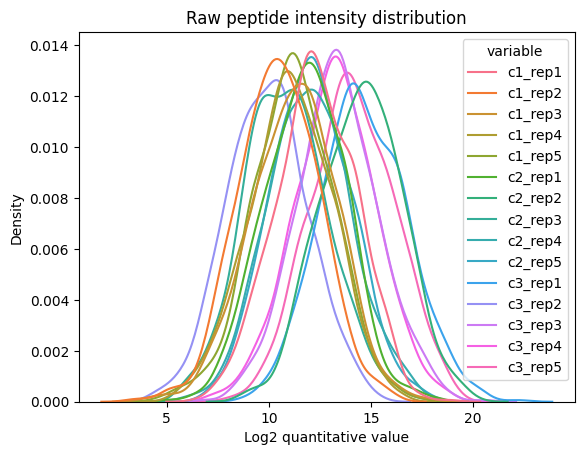

In [57]:
config = {
    # since we create a PeptidesDataset, id_col points to the peptide identifier column
    'id_col': 'peptide_id',
    # specify columns of the experimental conditions and their related experiments
    'conditions': {
        'c1': ['c1_rep1', 'c1_rep2', 'c1_rep3', 'c1_rep4', 'c1_rep5'],
        'c2': ['c2_rep1', 'c2_rep2', 'c2_rep3', 'c2_rep4', 'c2_rep5'],
        'c3': ['c3_rep1', 'c3_rep2', 'c3_rep3', 'c3_rep4', 'c3_rep5'],
    },
    # specify the column name of the protein identifier, so that you can calculate protein abundance values in the end
    'protein_id_col': 'protein_id',
}
raw_pept_dset = PeptidesDataset.from_df(data_df, **config)

plot_density(
    dataset=raw_pept_dset,
    log_transform=True,
    xlabel='Log2 quantitative value',
    ylabel='Density',
    title='Raw peptide intensity distribution')
plt.show()


To normalize the dataset, call the `.normalize` method.
Currently, only normalization to the mean value of the peptide distribution is supported with extra options (see documentation).

When using the default values, the steps during the normalization include: 
1. Find the experiment with the most records and consider reference.
2. Calculate mean experiment intensity and the difference from reference.
3. Shift each experiment's intensity by the difference with reference.  

Optionally, you can set reference experiment with the `ref_exp` argument, or a reference experimental condition to automatically pick the reference using the `ref_condition` argument.

Note that normalization is done on normally distributed data. For this, you need to do any related transformation before and after that step. For example, you might use Log2 transformation before the normalization and back transform to the original scale afterward. 

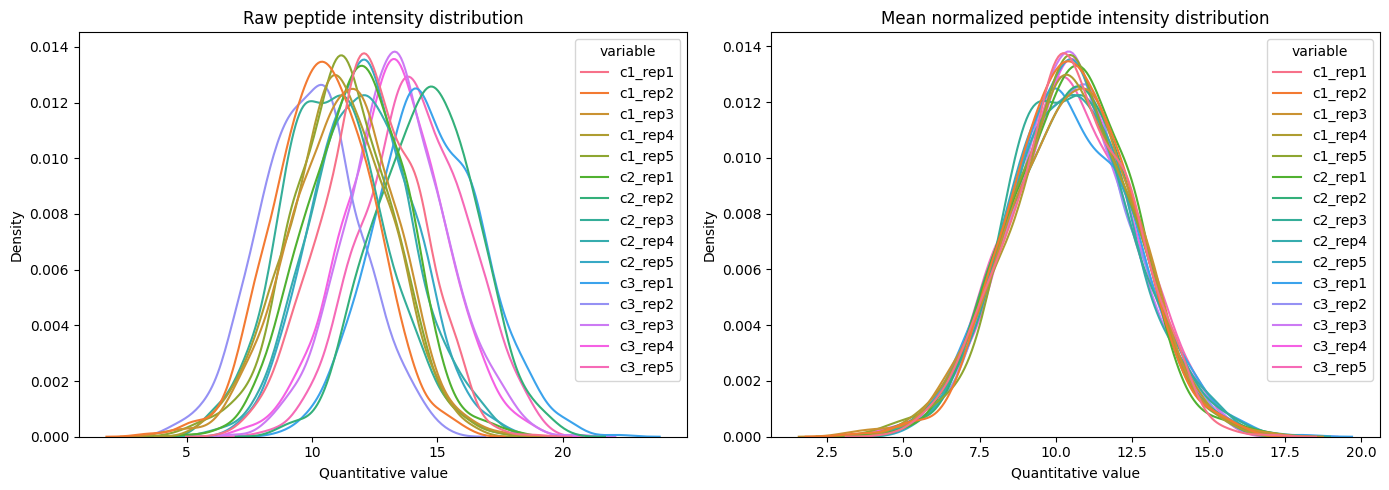

In [58]:
# normalize the dataset
norm_pept_dset = raw_pept_dset\
    .log2_transform()\
    .normalize(method='mean')\
    .log2_backtransform()

# plot before and after normalization
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_density(
    dataset=raw_pept_dset,
    log_transform=True,
    title='Raw peptide intensity distribution',
    ax=ax[0])

plot_density(
    dataset=norm_pept_dset, 
    log_transform=True,
    title='Mean normalized peptide intensity distribution', 
    ax=ax[1])
plt.tight_layout()
plt.show()
# pept_df

Finally, use the normalized peptide values to calculate protein abundance as the sum of peptide abundance values, and continue your analysis pipeline.

In [59]:
proteins_dset = norm_pept_dset.to_proteins()
prot_df = proteins_dset.to_table()
prot_df.head(2)

,c1_rep1,c1_rep2,c1_rep3,c1_rep4,c1_rep5,c2_rep1,c2_rep2,c2_rep3,c2_rep4,c2_rep5,c3_rep1,c3_rep2,c3_rep3,c3_rep4,c3_rep5
protein_id,,,,,,,,,,,,,,,
prot0,31591.837412,13990.809596,12324.678681,22023.734731,14694.277136,14427.119874,45839.563199,59211.802455,23086.862365,22146.803428,31218.149389,28015.428540,54998.218152,97102.374965,15396.715568
prot1,34552.115281,69917.183544,41572.100739,7044.607483,8136.515734,8993.403622,26526.500835,21703.822784,31303.386236,49314.501471,21025.427164,53153.792459,6947.123719,19045.165135,52347.668785
